In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!unzip '/content/drive/My Drive/DATASETS/intel-image-classification.zip' -d 'intel-image-classification/'


Archive:  /content/drive/My Drive/DATASETS/intel-image-classification.zip
  inflating: intel-image-classification/seg_train.zip  
  inflating: intel-image-classification/seg_test.zip  
  inflating: intel-image-classification/seg_pred.zip  


In [0]:
!unzip 'intel-image-classification/seg_train.zip' -d 'intel-image-classification/seg_train/'
!unzip 'intel-image-classification/seg_test.zip' -d 'intel-image-classification/seg_test/'
!unzip 'intel-image-classification/seg_pred.zip' -d 'intel-image-classification/seg_pred/'

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Input, ZeroPadding2D, Conv2D, MaxPooling2D, Activation, add
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import tensorflow.keras
from tensorflow.keras.layers import Conv2D, Dropout, MaxPool2D, AvgPool2D, Add, Dense 
from tensorflow.keras.preprocessing.image import load_img, img_to_array


from keras.models import Model

from keras.utils import plot_model

import warnings
#warnings.warn("ignore")
import os

Using TensorFlow backend.


In [0]:
#!unzip 'intel-image-classification.zip'

In [0]:
from keras.preprocessing.image import load_img, img_to_array
import os

def convert(path,y):
    array=[]
    img_cat = []
    for img_path in os.listdir(path):
        img = load_img(path + img_path, target_size=(150,150))
        img = img_to_array(img)
        img = img/255.
        array.append(img)
        img_cat.append(y)
    return np.array(array), np.array(img_cat)

In [0]:
trainX_building, trainY_building  = convert("intel-image-classification/seg_train/seg_train/buildings/",0)
trainX_forest,trainY_forest  = convert("intel-image-classification/seg_train/seg_train/forest/",1)
trainX_glacier,trainY_glacier  = convert("intel-image-classification/seg_train/seg_train/glacier/",2)
trainX_mount,trainY_mount  = convert("intel-image-classification/seg_train/seg_train/mountain/",3)
trainX_sea,trainY_sea  = convert("intel-image-classification/seg_train/seg_train/sea/",4)
trainX_street,trainY_street  = convert("intel-image-classification/seg_train/seg_train/street/",5)

print('train building shape ', trainX_building.shape, trainY_building.shape) 
print('train forest', trainX_forest.shape ,trainY_forest.shape)
print('train glacier', trainX_glacier.shape,trainY_glacier.shape)
print('train mountain', trainX_mount.shape, trainY_mount.shape)
print('train sea',     trainX_sea.shape, trainY_sea.shape)
print('train street', trainX_street.shape ,trainY_street.shape)

train building shape  (2191, 150, 150, 3) (2191,)
train forest (2271, 150, 150, 3) (2271,)
train glacier (2404, 150, 150, 3) (2404,)
train mountain (2512, 150, 150, 3) (2512,)
train sea (2274, 150, 150, 3) (2274,)
train street (2382, 150, 150, 3) (2382,)


In [0]:
X_train= np.concatenate((trainX_building,trainX_forest, trainX_glacier,trainX_mount, trainX_sea,trainX_street),axis=0)
y_train= np.concatenate((trainY_building,trainY_forest, trainY_glacier,trainY_mount, trainY_sea,trainY_street),axis=0)

In [0]:
testX_building, testY_building  = convert("intel-image-classification/seg_test/seg_test/buildings/",0)
testX_forest,testY_forest  = convert("intel-image-classification/seg_test/seg_test/forest/",1)
testX_glacier,testY_glacier  = convert("intel-image-classification/seg_test/seg_test/glacier/",2)
testX_mount,testY_mount  = convert("intel-image-classification/seg_test/seg_test/mountain/",3)
testX_sea,testY_sea  = convert("intel-image-classification/seg_test/seg_test/sea/",4)
testX_street,testY_street  = convert("intel-image-classification/seg_test/seg_test/street/",5)

print('test building shape ', testX_building.shape, testY_building.shape) 
print('test forest', testX_forest.shape ,testY_forest.shape)
print('test glacier', testX_glacier.shape,testY_glacier.shape)
print('test mountain', testX_mount.shape, testY_mount.shape)
print('test sea',     testX_sea.shape, testY_sea.shape)
print('test street', testX_street.shape ,testY_street.shape)

test building shape  (437, 150, 150, 3) (437,)
test forest (474, 150, 150, 3) (474,)
test glacier (553, 150, 150, 3) (553,)
test mountain (525, 150, 150, 3) (525,)
test sea (510, 150, 150, 3) (510,)
test street (501, 150, 150, 3) (501,)


In [0]:
X_test= np.concatenate((testX_building,testX_forest, testX_glacier,testX_mount, testX_sea,testX_street),axis=0)
y_test= np.concatenate((testY_building,testY_forest, testY_glacier,testY_mount, testY_sea,testY_street),axis=0)

In [0]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14034, 150, 150, 3), (3000, 150, 150, 3), (14034,), (3000,))

In [0]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train.shape,y_test.shape
y_test[1]

array([1., 0., 0., 0., 0., 0.], dtype=float32)

In [0]:
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    # 5x5 conv
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

In [0]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


In [0]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [0]:
def DeepResNetInception(input_shape = (150, 150, 3), classes = 6):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

   
    # Zero-Padding
    #X = ZeroPadding2D((3, 3))(X_input)
    X = X_input
    
    # Stage 1
    X = Conv2D(16, (3, 3), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)

    # Stage 2
    X = Conv2D(32, (3, 3), strides = (2, 2), name = 'conv2', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv2')(X)
    X = Activation('relu')(X)

    
    # Stage 3
    X = Conv2D(64, (3, 3), strides = (2, 2), name = 'conv3', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv3')(X)
    X = Activation('relu')(X)
       

    # inception module (out 128)
    X = inception_module(X, f1=32, f2_in=(32+8), f2_out=64, f3_in=8, f3_out=16, f4_out=16)
    X = BatchNormalization(axis = 3, name = 'bn_conv4')(X)
    X = Activation('relu')(X)    

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [128, 128, 256], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 256], stage=4, block='b')
    X = BatchNormalization(axis = 3, name = 'bn_conv5')(X)
    X = Activation('relu')(X)    
    
    # inception module (out 256)
    X = inception_module(X, f1=64, f2_in=(64+16), f2_out=128, f3_in=16, f3_out=32, f4_out=32)
    X = BatchNormalization(axis = 3, name = 'bn_conv6')(X)
    X = Activation('relu')(X)    

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [256, 128, 512], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 512], stage=5, block='b')
    X = BatchNormalization(axis = 3, name = 'bn_conv7')(X)
    X = Activation('relu')(X)
    
    # inception module (out 512)
    X = inception_module(X, f1=128, f2_in=(128+32), f2_out=256, f3_in=32, f3_out=64, f4_out=64)
    X = BatchNormalization(axis = 3, name = 'bn_conv8')(X)
    X = Activation('relu')(X)    

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 1024], stage = 6, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 1024], stage=6, block='b')
    X = BatchNormalization(axis = 3, name = 'bn_conv9')(X)
    X = Activation('relu')(X)    



    # AVGPOOL
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    #X = Dropout(0.25)(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes),  kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='DeepRes-ception')

    return model

In [0]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
import tensorflow as tf

from keras.layers.merge import concatenate

In [0]:
img_shape = (150, 150, 3)
model = DeepResNetInception(input_shape=img_shape, classes=6)

In [0]:
#model.load_weights("Deep-Res-ception-v8_weights.h5")

In [0]:
model.summary()

Model: "DeepRes-ception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 74, 74, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 74, 74, 16)   64          conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 16)   0           bn_conv1[0][0]                   
____________________________________________________________________________________

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
#model.load_weights("Deep-Res-ception-v8_weights.h5")

In [0]:
trained_model = model.fit(X_train, y_train, epochs = 50, batch_size = 64, validation_data=(X_test, y_test), shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 14034 samples, validate on 3000 samples
Epoch 1/50
14034/14034 [==============================] - 66s 5ms/step - loss: 1.1687 - acc: 0.5606 - val_loss: 1.2113 - val_acc: 0.6093
Epoch 2/50
14034/14034 [==============================] - 51s 4ms/step - loss: 0.7070 - acc: 0.7344 - val_loss: 0.7647 - val_acc: 0.7257
Epoch 3/50
14034/14034 [==============================] - 50s 4ms/step - loss: 0.5591 - acc: 0.7983 - val_loss: 0.7842 - val_acc: 0.7300
Epoch 4/50
14034/14034 [==============================] - 50s 4ms/step - loss: 0.4642 - acc: 0.8342 - val_loss: 0.8185 - val_acc: 0.7337
Epoch 5/50
14034/14034 [==============================] - 51s 4ms/step - loss: 0.4042 - acc: 0.8536 - val_loss: 1.8421 - val_acc: 0.5247
Epoch 6/50
14034/14034 [==============================] - 50s 4ms/step - loss: 0.3444 - acc: 0.8762 - val_loss: 0.7252 - val_acc: 0.7320
Epoch 7/50
14034/14034 [=========

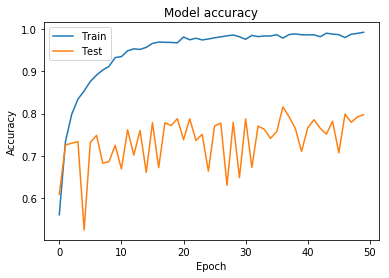

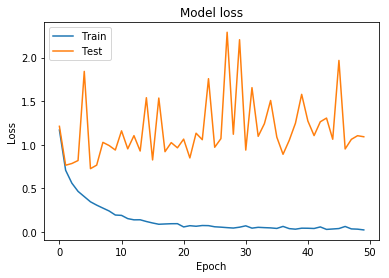

In [0]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(trained_model.history['acc'])
plt.plot(trained_model.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
model.evaluate(X_test, y_test)

3000/3000 [==============================] - 5s 2ms/step


[1.0914814795851708, 0.7973333334922791]

In [0]:
model.save_weights('Deep-Res-ception_v2_without_da_weights.h5')

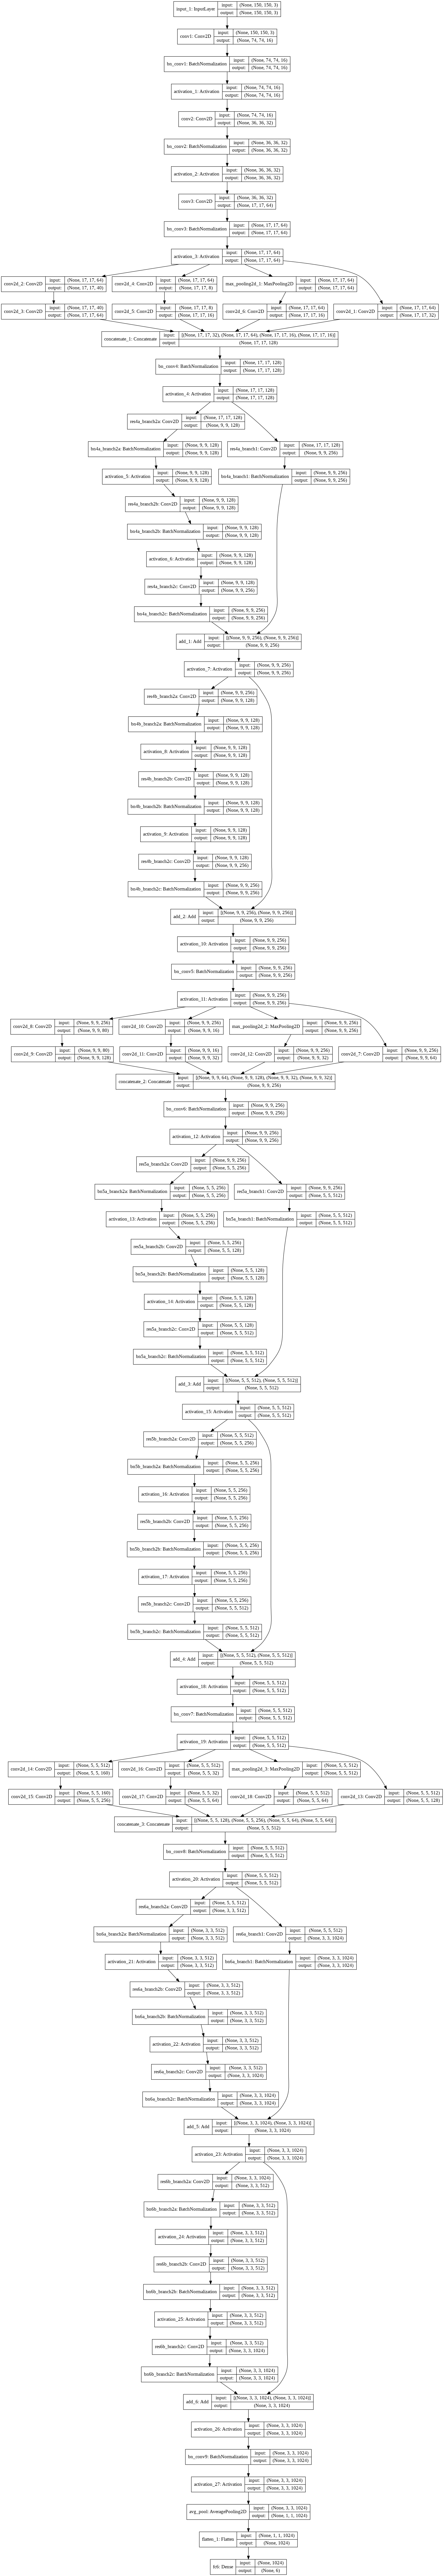

In [0]:
plot_model(model, show_shapes=True, to_file='Deep-Res-Inception-V2-noDA.png')